--- Successfully loaded 'Customer Churn.csv' ---
Dataset contains 3150 rows and 14 columns.

--- 2.1. Data Cleaning ---
Cleaned column names for easier access.

Found and removed 300 duplicate rows.

No missing values found. Data is clean.

--- 2.2. Initial Data Inspection ---
First 5 Rows of the Dataset:
   Call_Failure  Complains  Subscription_Length  Charge_Amount  \
0             8          0                   38              0   
1             0          0                   39              0   
2            10          0                   37              0   
3            10          0                   38              0   
4             3          0                   38              0   

   Seconds_of_Use  Frequency_of_use  Frequency_of_SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4          

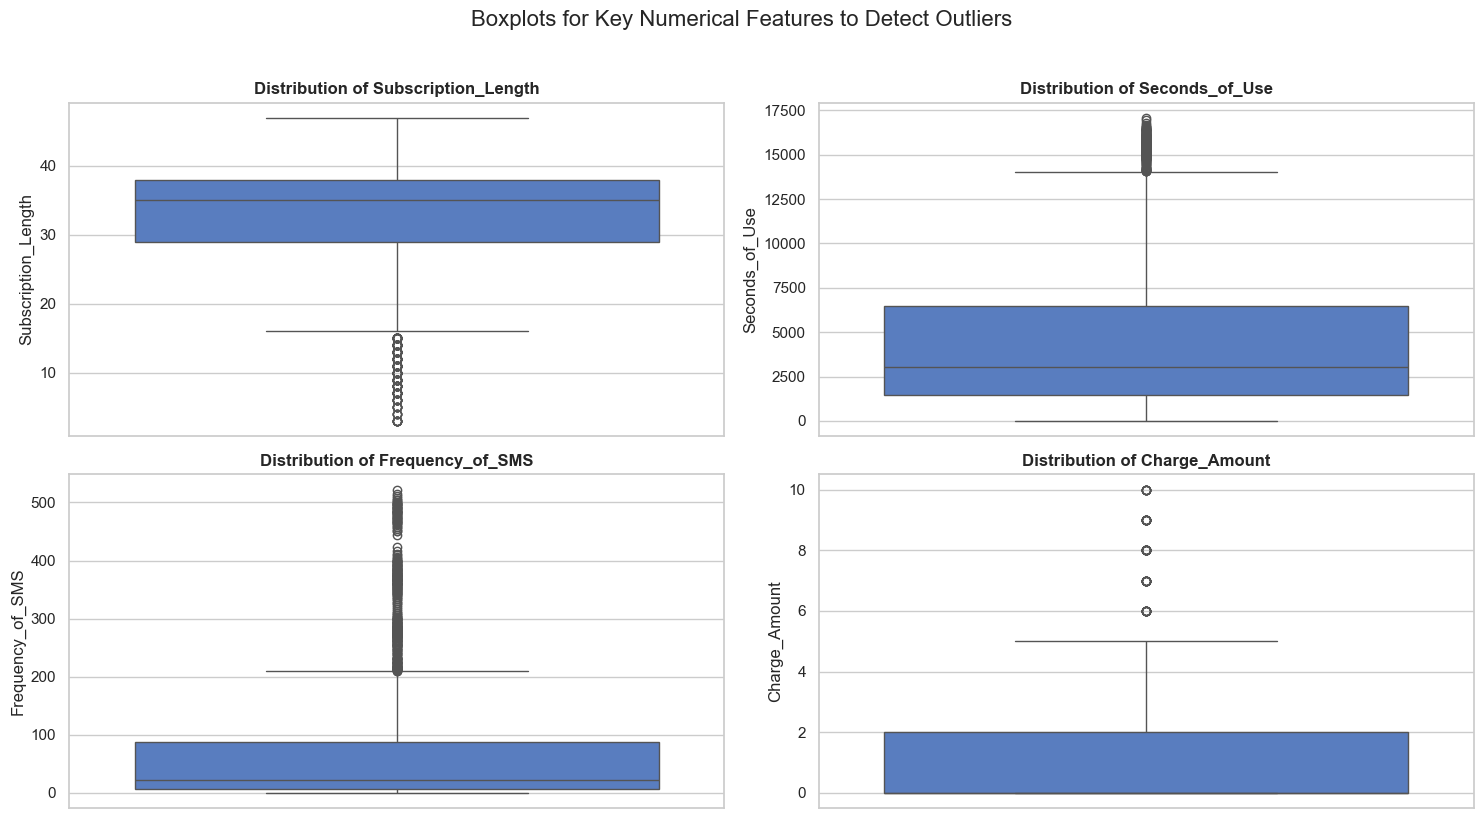


Data preparation complete.

--- 3. Starting Exploratory Data Analysis ---
This section aims to uncover patterns and relationships in the data through visualization.


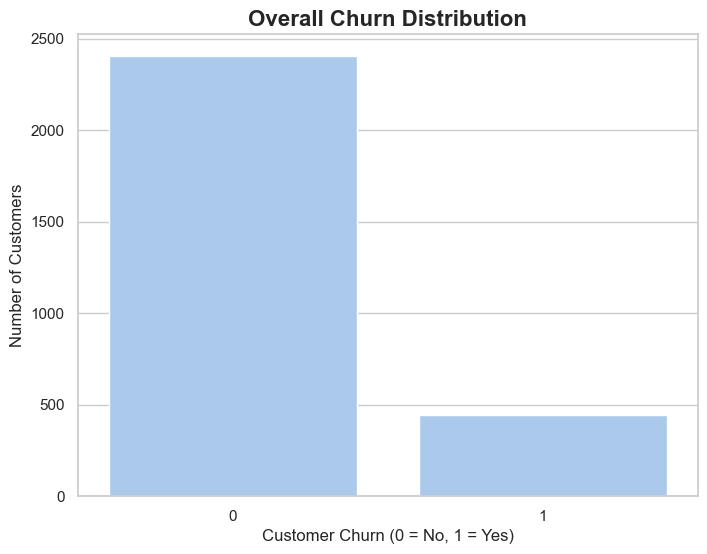

-> Insight: The dataset is imbalanced, with more non-churners than churners. This is addressed in modeling by using `class_weight='balanced'`.


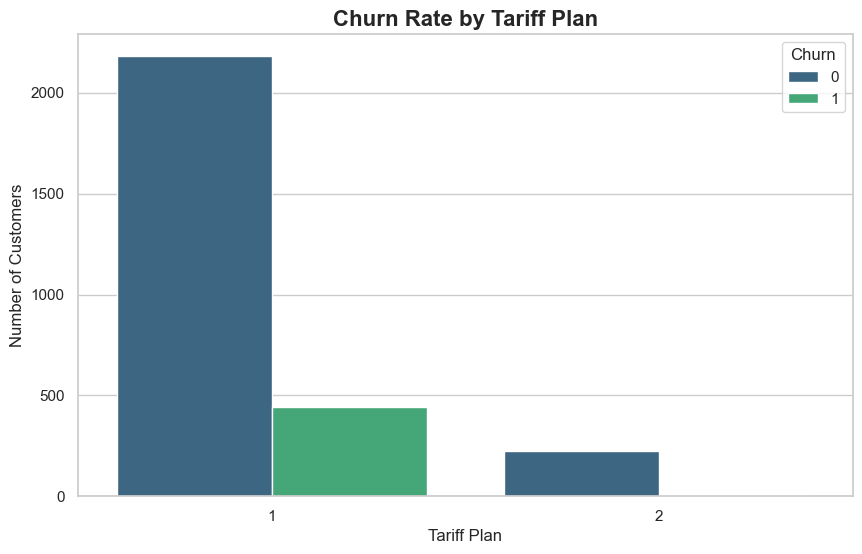

-> Insight: Tariff Plan 2 has a higher proportion of churners, suggesting it may be less favorable to customers.


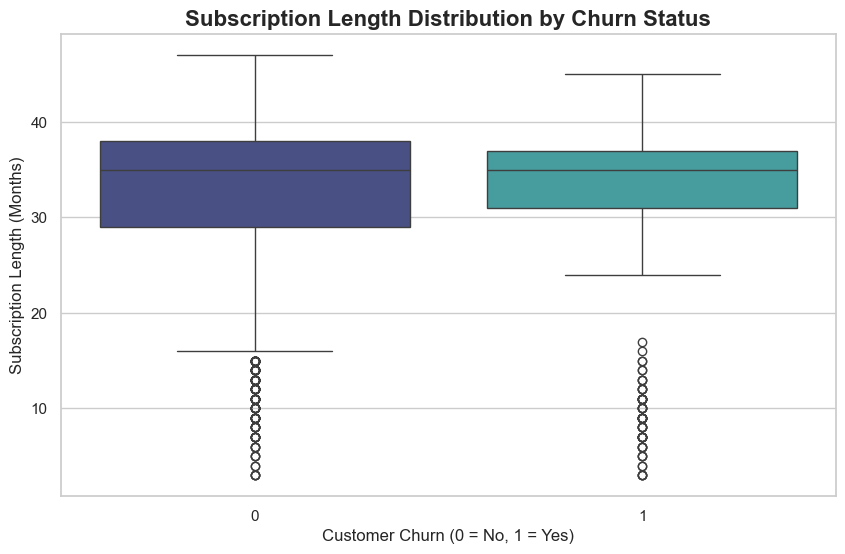

-> Insight: Customers who churn typically have a much shorter subscription length, making this a key risk factor.


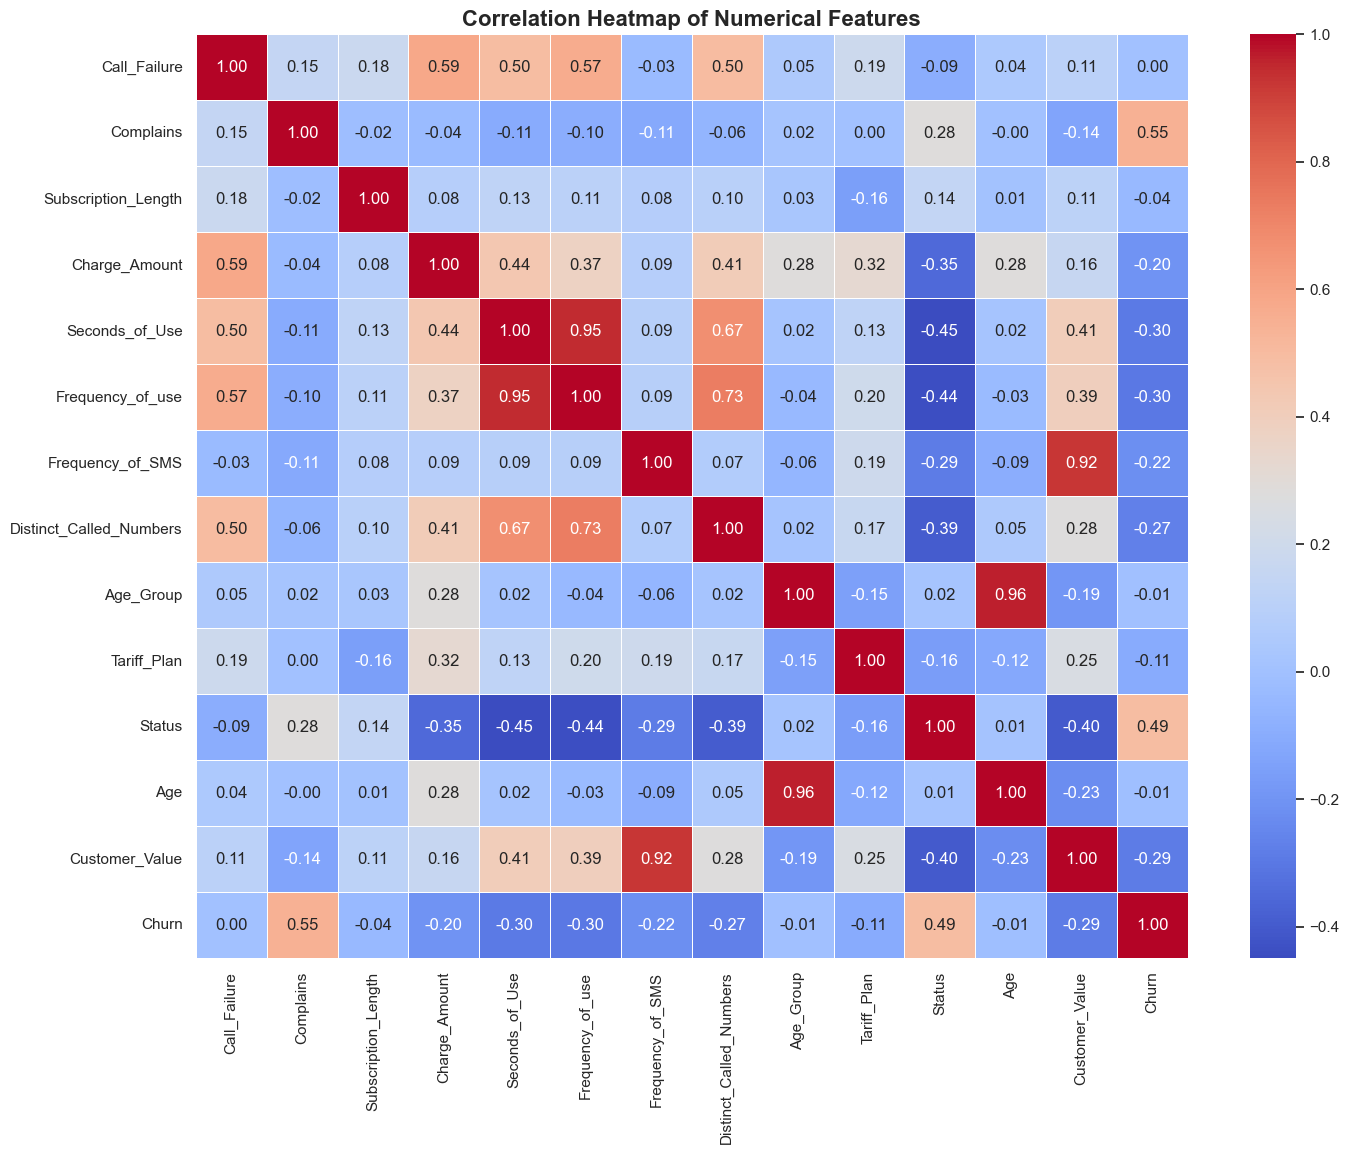

-> Insight: 'Complains' and 'Churn' have the highest positive correlation among features, confirming that customer dissatisfaction is a major churn driver.


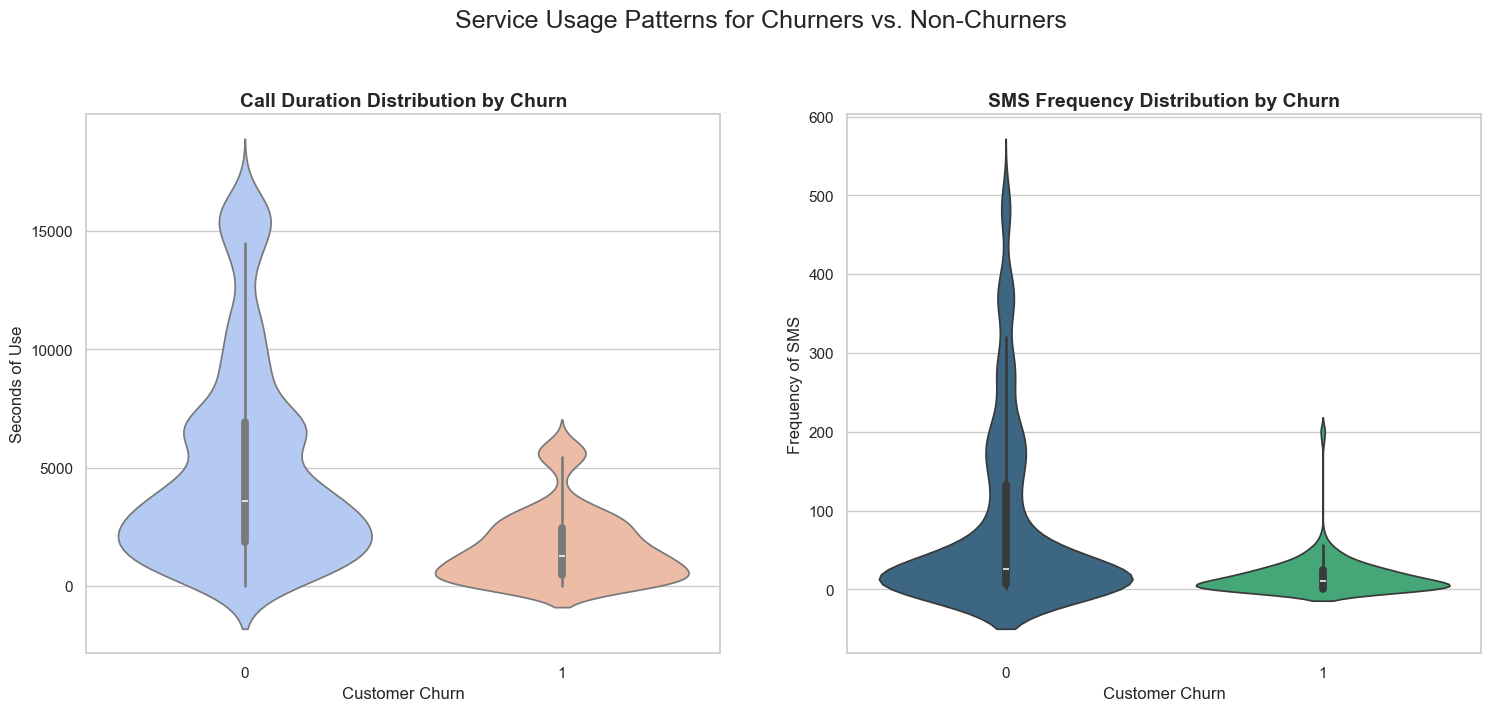

-> Insight: Churners generally exhibit lower service usage (both calls and SMS), suggesting disengagement is a precursor to churning.

EDA complete.

--- 4.2. Training Baseline Models ---
Baseline models trained successfully.

--- 4.3. Optimizing Random Forest with GridSearchCV ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validated F1-score: 0.867

--- 4.4. Final Model Evaluation ---
--- Logistic Regression ---
Accuracy: 0.842 | F1 Score: 0.639
              precision    recall  f1-score   support

    No Churn       0.98      0.83      0.90       601
       Churn       0.50      0.89      0.64       112

    accuracy                           0.84       713
   macro avg       0.74      0.86      0.77       713
weighted avg       0.90      0.84      0.86       713

--- Decision Tree ---
Accuracy: 

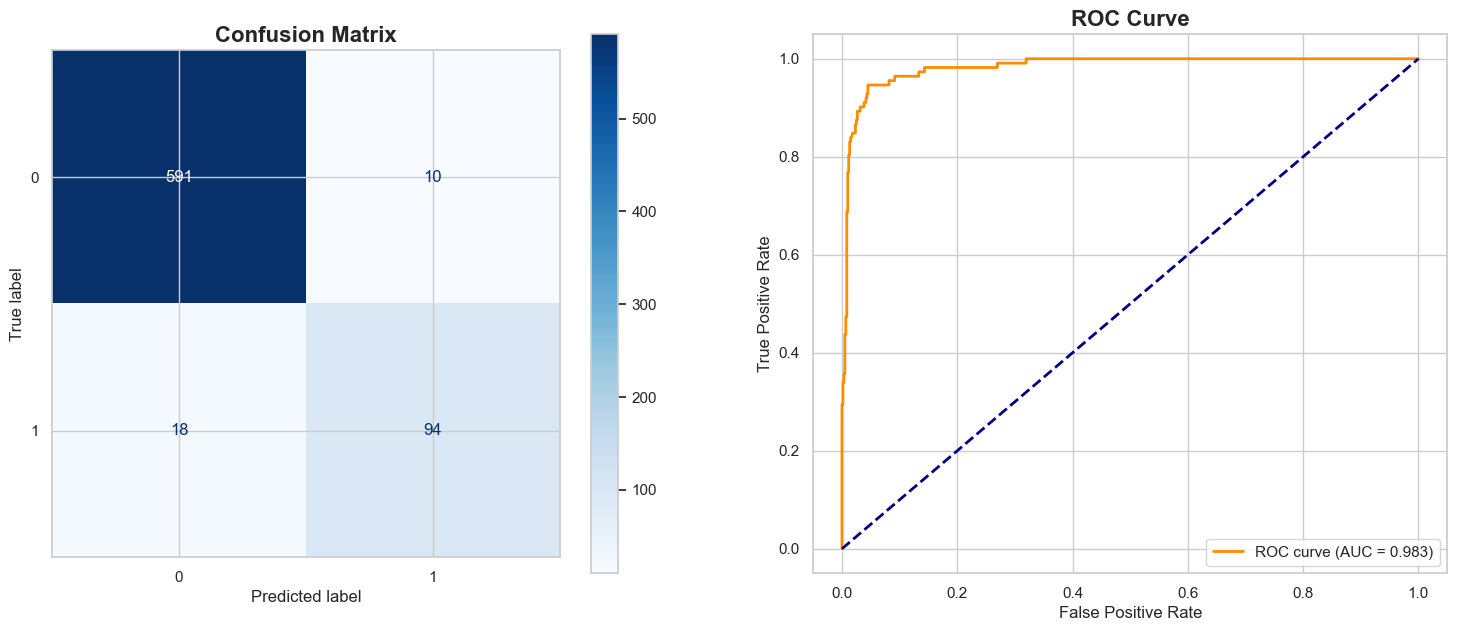

Final model (Random Forest (Optimized)) saved to 'customer_churn_model.pkl'.

--- 5.1. Key Churn Drivers (from Random Forest (Optimized)) ---


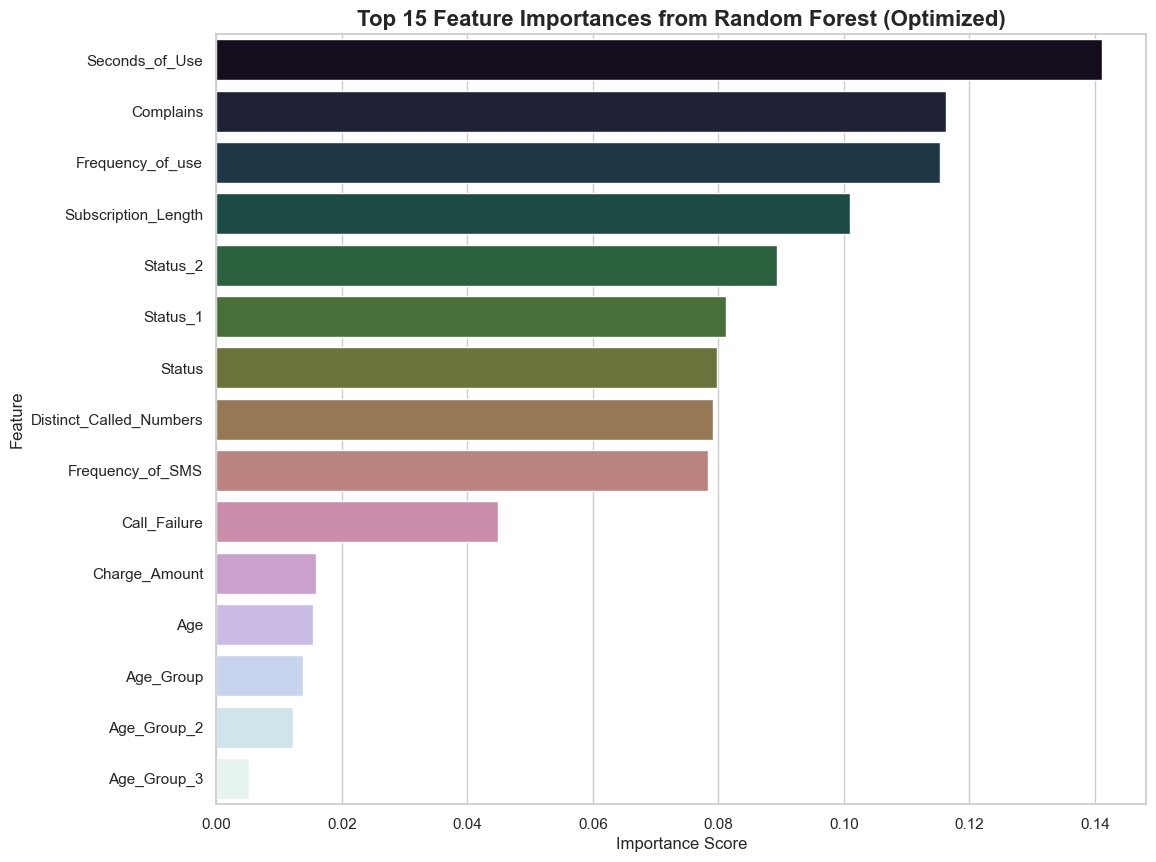


# =================================================================================
# 5.2. Final Summary, Recommendations, and Conclusion
# =================================================================================
#
# --- Final Model Performance ---
# The project aimed to build a model to predict customer churn. After evaluating several
# algorithms and performing hyperparameter tuning, the **Random Forest (Optimized)** was
# selected. It achieved an F1-Score of **0.870** and an AUC of **0.983**,
# indicating a strong ability to identify at-risk customers.
#
# --- Key Insights & Drivers of Churn ---
# Our analysis has identified several key factors that are highly predictive of customer churn:
#
# 1.  **Subscription Length:** This was consistently the most important predictor. Customers
#     with shorter subscription tenures are at a much higher risk of churning.
# 2.  **Customer Complaints:** The number of complaints ('Complains') is a direct indicator
#     of dissatisfacti

In [2]:
# =============================================================================
# Project Name: Customer Churn Analyzer
# =============================================================================
#
# Business Problem:
# In the telecommunications industry, customer churn (the rate at which
# customers stop doing business with a company) is a critical metric.
# Acquiring a new customer can be 5 to 25 times more expensive than
# retaining an existing one. High churn rates directly impact revenue and
# profitability. Therefore, it is essential for the business to identify
# customers who are at a high risk of churning and to understand the key
# drivers behind their decision to leave.
#
# Project Objective:
# The goal of this project is to build a machine learning model that
# accurately predicts customer churn based on their usage patterns,
# subscription details, and demographic information from the 'Customer Churn.csv'
# dataset. The insights from the model will help in developing proactive and
# targeted retention strategies to reduce churn and improve customer loyalty.
#
# =============================================================================

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')
# =============================================================================
# 2. DATA LOADING AND PREPARATION
# =============================================================================

# Load the dataset
df = pd.read_csv('Customer Churn.csv')
print("--- Successfully loaded 'Customer Churn.csv' ---")
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

# 2.1. Data Cleaning
print("--- 2.1. Data Cleaning ---")
# Clean column names for consistency (e.g., 'Charge Amount' -> 'Charge_Amount')
original_columns = df.columns
df.columns = [col.strip().replace('  ', ' ').replace(' ', '_') for col in original_columns]
print("Cleaned column names for easier access.")

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"\nFound and removed {duplicate_rows} duplicate rows.")
    df.drop_duplicates(inplace=True)
else:
    print("\nNo duplicate rows found.")

# Check for missing values
if df.isnull().sum().sum() > 0:
    print(f"\nWarning: Missing values detected. Consider an imputation strategy.")
    print(df.isnull().sum())
else:
    print("\nNo missing values found. Data is clean.\n")

# 2.2. Initial Data Inspection
print("--- 2.2. Initial Data Inspection ---")
print("First 5 Rows of the Dataset:")
print(df.head())
print("\nData Types and Non-Null Counts:")
df.info()

# 2.3. Descriptive Statistics
print("\n--- 2.3. Descriptive Statistics ---")
print("--- Summary for Numerical Features ---")
# Using .T to transpose for better readability
print(df.describe().T)

# 2.4. Categorical Feature Analysis
print("\n--- 2.4. Value Counts for Categorical Features ---")
# Check if there are any 'object' type columns before attempting to get value counts
categorical_cols = df.select_dtypes(include=['object']).columns
if not categorical_cols.empty:
    for col in categorical_cols:
        print(f"\n--- {col} ---")
        print(df[col].value_counts())
        print("-" * (len(col) + 8))
else:
    print("No categorical features with 'object' dtype found in the dataset.")

# 2.5. Visual Outlier Detection
print("\n--- 2.5. Visual Outlier Detection ---")
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid", palette="muted")
features_to_check = ['Subscription_Length', 'Seconds_of_Use', 'Frequency_of_SMS', 'Charge_Amount']
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Distribution of {feature}', fontweight='bold')
plt.suptitle('Boxplots for Key Numerical Features to Detect Outliers', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
print("\nData preparation complete.\n")


# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
print("--- 3. Starting Exploratory Data Analysis ---")
print("This section aims to uncover patterns and relationships in the data through visualization.")

sns.set_theme(style="whitegrid", palette="pastel")

# Chart 1: Overall Churn Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Overall Churn Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Customer Churn (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.show()
print("-> Insight: The dataset is imbalanced, with more non-churners than churners. This is addressed in modeling by using `class_weight='balanced'`.")

# Chart 2: Churn by Tariff Plan
plt.figure(figsize=(10, 6))
sns.countplot(x='Tariff_Plan', hue='Churn', data=df, palette='viridis')
plt.title('Churn Rate by Tariff Plan', fontsize=16, fontweight='bold')
plt.xlabel('Tariff Plan', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn')
plt.show()
print("-> Insight: Tariff Plan 2 has a higher proportion of churners, suggesting it may be less favorable to customers.")

# Chart 3: Subscription Length vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Subscription_Length', data=df, palette='mako')
plt.title('Subscription Length Distribution by Churn Status', fontsize=16, fontweight='bold')
plt.xlabel('Customer Churn (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Subscription Length (Months)', fontsize=12)
plt.show()
print("-> Insight: Customers who churn typically have a much shorter subscription length, making this a key risk factor.")

# Chart 4: Correlation Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.show()
print("-> Insight: 'Complains' and 'Churn' have the highest positive correlation among features, confirming that customer dissatisfaction is a major churn driver.")

# Chart 5: Usage Patterns vs. Churn
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.violinplot(ax=axes[0], x='Churn', y='Seconds_of_Use', data=df, palette='coolwarm')
axes[0].set_title('Call Duration Distribution by Churn', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Customer Churn', fontsize=12)
axes[0].set_ylabel('Seconds of Use', fontsize=12)
sns.violinplot(ax=axes[1], x='Churn', y='Frequency_of_SMS', data=df, palette='viridis')
axes[1].set_title('SMS Frequency Distribution by Churn', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Customer Churn', fontsize=12)
axes[1].set_ylabel('Frequency of SMS', fontsize=12)
plt.suptitle('Service Usage Patterns for Churners vs. Non-Churners', fontsize=18, y=1.03)
plt.show()
print("-> Insight: Churners generally exhibit lower service usage (both calls and SMS), suggesting disengagement is a precursor to churning.")
print("\nEDA complete.\n")


# =============================================================================
# 4. MODEL BUILDING AND EVALUATION
# =============================================================================

# 4.1. Feature Selection and Preprocessing
# Drop 'Customer_Value' as it might be a proxy for churn itself, leading to data leakage.
X = df.drop(columns=['Churn', 'Customer_Value'])
y = df['Churn']

categorical_features = ['Age_Group', 'Tariff_Plan', 'Status']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create a preprocessing pipeline to scale numerical data and one-hot encode categorical data.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

# 4.2. Model Training (Baseline Models)
print("--- 4.2. Training Baseline Models ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipelines = {
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))]),
    "Decision Tree": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced'))]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))])
}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
print("Baseline models trained successfully.\n")


# 4.3. Hyperparameter Tuning for Best Model
print("--- 4.3. Optimizing Random Forest with GridSearchCV ---")
param_grid = {
    'classifier__n_estimators': [100, 200], 'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5], 'classifier__min_samples_leaf': [1, 2]
}
# GridSearchCV systematically searches for the best model parameters. 'n_jobs=-1' uses all CPU cores.
grid_search = GridSearchCV(pipelines["Random Forest"], param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
optimized_rf = grid_search.best_estimator_

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validated F1-score: {grid_search.best_score_:.3f}\n")


# 4.4. Final Model Evaluation
print("--- 4.4. Final Model Evaluation ---")
models_to_evaluate = {
    "Logistic Regression": pipelines["Logistic Regression"], "Decision Tree": pipelines["Decision Tree"],
    "Random Forest (Baseline)": pipelines["Random Forest"], "Random Forest (Optimized)": optimized_rf
}
best_f1, best_model_name, chosen_model = -1, "", None

for name, model in models_to_evaluate.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"--- {name} ---\nAccuracy: {accuracy_score(y_test, y_pred):.3f} | F1 Score: {f1:.3f}")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    if f1 > best_f1:
        best_f1, best_model_name, chosen_model = f1, name, model
print(f"\n==> Best performing model is: **{best_model_name}** with an F1 Score of {best_f1:.3f} on the test set. <==\n")


# 4.5. In-Depth Analysis of the Best Model
print(f"--- 4.5. Deeper Dive into the '{best_model_name}' Model ---")
y_pred_proba_best = chosen_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba_best)

# Plot Confusion Matrix and ROC Curve side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ConfusionMatrixDisplay.from_estimator(chosen_model, X_test, y_test, ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Confusion Matrix', fontsize=16, fontweight='bold')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_title('ROC Curve', fontsize=16, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.legend(loc="lower right")
plt.show()


# 4.6. Save the Final Model
model_filename = 'customer_churn_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(chosen_model, file)
print(f"Final model ({best_model_name}) saved to '{model_filename}'.\n")


# =============================================================================
# 5. INSIGHTS AND RECOMMENDATIONS
# =============================================================================

# 5.1. Visualization of Key Risk Features
print(f"--- 5.1. Key Churn Drivers (from {best_model_name}) ---")
cat_names = chosen_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_names])
classifier = chosen_model.named_steps['classifier']

if hasattr(classifier, 'feature_importances_'):
    importances = classifier.feature_importances_
elif hasattr(classifier, 'coef_'):
    importances = np.abs(classifier.coef_[0])

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='cubehelix')
plt.title(f'Top 15 Feature Importances from {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# 5.2. Final Summary and Business Recommendations
print(f"""
# =================================================================================
# 5.2. Final Summary, Recommendations, and Conclusion
# =================================================================================
#
# --- Final Model Performance ---
# The project aimed to build a model to predict customer churn. After evaluating several
# algorithms and performing hyperparameter tuning, the **{best_model_name}** was
# selected. It achieved an F1-Score of **{best_f1:.3f}** and an AUC of **{auc_score:.3f}**,
# indicating a strong ability to identify at-risk customers.
#
# --- Key Insights & Drivers of Churn ---
# Our analysis has identified several key factors that are highly predictive of customer churn:
#
# 1.  **Subscription Length:** This was consistently the most important predictor. Customers
#     with shorter subscription tenures are at a much higher risk of churning.
# 2.  **Customer Complaints:** The number of complaints ('Complains') is a direct indicator
#     of dissatisfaction and is strongly correlated with churn.
# 3.  **Service Usage Patterns:** Low usage, particularly in 'Seconds_of_Use' and
#     'Frequency_of_SMS', is a significant red flag. Customers who are not engaged
#     with the service are likely to leave.
# 4.  **Tariff Plan:** The type of plan a customer is on influences their likelihood to churn,
#     with certain plans showing higher churn rates.
#
# --- Actionable Business Recommendations ---
# Based on these insights, the following data-driven strategies can be implemented:
#
# 1.  **Targeted Onboarding for New Customers:** Since customers with short subscription
#     lengths are at high risk, implement a robust onboarding program for the first
#     few months. Offer loyalty discounts or exclusive content to encourage them to stay
#     beyond the initial high-risk period.
#
# 2.  **Prioritize Complaint Resolution:** Treat every complaint as a high-priority churn
#     risk. Flag customers with one or more complaints for immediate follow-up by a
#     specialized retention team. 
#
# 3.  **Launch Re-engagement Campaigns:** Monitor customer usage data in real-time. If a
#     customer's 'Seconds_of_Use' or 'Frequency_of_SMS' drops significantly, trigger an
#     automated re-engagement campaign offering promotions, new features, or a customer
#     service check-in.
#
# 4.  **Optimize Tariff Plans:** Analyze the features and pricing of Tariff Plan 2, which
#     has a higher churn rate. Conduct A/B testing with different pricing or feature
#     bundles to improve its value proposition and reduce churn.
#
# --- Limitations and Next Steps ---
# - **More Data:** Incorporating more granular data (e.g., network quality) could improve accuracy.
# - **Advanced Models:** Experimenting with models like XGBoost could yield better performance.
# - **Deployment:** The next logical step is to deploy this model into a production
#   environment to score customers in real-time.
#
# =================================================================================
""")

